In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
# 设置全局图表大小
plt.rc('figure', figsize=(12, 8))
plt.rc('axes', titlesize=18)  # 设置轴标题的字体大小
plt.rc('axes', labelsize=14)  # 设置轴标签的字体大小
plt.rc('xtick', labelsize=12)  # 设置x轴刻度标签的字体大小
plt.rc('ytick', labelsize=12)  # 设置y轴刻度标签的字体大小
plt.rc('legend', fontsize=12)  # 设置图例的字体大小

df = pd.read_csv('./data/classify_data.csv')

# # 衍生列
# add_columns = ['season', 'day_time', 'weekday', 'day_of_year', 'week_of_month', 'week_of_year'
#               ,'weekend', 'day', 'minute',  'month', 'hours']

# df.drop(add_columns, axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361346 entries, 0 to 361345
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   score          361346 non-null  float64
 1   hashtag        361346 non-null  object 
 2   lang           361346 non-null  object 
 3   tweet_lang     361346 non-null  object 
 4   time_zone      361346 non-null  object 
 5   track_id       361346 non-null  object 
 6   timestamp      361346 non-null  object 
 7   season         361346 non-null  object 
 8   day_time       361346 non-null  object 
 9   weekday        361346 non-null  int64  
 10  day_of_year    361346 non-null  int64  
 11  week_of_month  361346 non-null  int64  
 12  week_of_year   361346 non-null  int64  
 13  weekend        361346 non-null  bool   
 14  day            361346 non-null  int64  
 15  minute         361346 non-null  int64  
 16  month          361346 non-null  int64  
 17  hours          361346 non-nul

In [39]:
# track_to_label = pd.read_csv('./data/track_to_labels_dbscan.csv')
track_to_label = pd.read_csv('./data/track_to_labels_kmeans_5.csv')
track_to_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26911 entries, 0 to 26910
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   track_id  26911 non-null  object
 1   labels    26911 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 420.6+ KB


In [40]:
df = df.merge(track_to_label, on='track_id', how='left')
df.head()

,score,hashtag,lang,tweet_lang,time_zone,track_id,timestamp,season,day_time,weekday,day_of_year,week_of_month,week_of_year,weekend,day,minute,month,hours,labels
0,0.8,kiss92,en,en,Beijing,3Px454rzMHtIRc9R04QSlB,2014-01-01 05:59:38,winter,Wee hours(00:00 - 6:00),3,1,1,1,False,1,59,1,5,3
1,0.8,kiss92,en,en,Beijing,5eaD4UEbmcXZe0buNHOM64,2014-01-01 06:06:15,winter,Morning(6:00 - 12:00),3,1,1,1,False,1,6,1,6,0
2,0.8,kiss92,en,en,Beijing,75VOiyc0bT0VkFFQuKakgE,2014-01-01 06:11:07,winter,Morning(6:00 - 12:00),3,1,1,1,False,1,11,1,6,0
3,0.8,kiss92,en,en,Beijing,0Dy1Q2uUKII4asOHvexBn9,2014-01-01 06:19:43,winter,Morning(6:00 - 12:00),3,1,1,1,False,1,19,1,6,2
4,0.8,kiss92,en,en,Beijing,777VRhgQZ1L2c0RJnLlNI9,2014-01-01 06:23:47,winter,Morning(6:00 - 12:00),3,1,1,1,False,1,23,1,6,1


In [41]:
df = df.dropna()
df.labels.value_counts()

0    115117
1     80024
3     77939
2     58511
4     29755
Name: labels, dtype: int64

In [42]:
# 去除离群点
df = df[df['labels'] != -1]
df.labels.value_counts()

0    115117
1     80024
3     77939
2     58511
4     29755
Name: labels, dtype: int64

In [43]:
#对分数score取平方、3次方
df['score_2'] = df['score'] ** 2
df['score_3'] = df['score'] ** 3

# 对情绪分数score进行分箱操作
labels = ['disgust', 'sadness', 'neutral', 'happiness', 'surprise']
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
df['mood'] = pd.cut(df['score'], labels=labels, bins = bins, include_lowest=True)
df['mood'] = df['mood'].astype('category')

df['mood_label'] = df['mood'].cat.codes
print(df[['mood', 'mood_label']])

bins = [0.0, 0.5, 1.0]
df['happy'] = pd.cut(df['score'], labels=[0, 1], bins = bins, include_lowest=True)
df['happy'] = df['happy'].cat.codes

if (df['labels'] >= 2).sum() > 0:
    df.to_csv('./data/final_classify_data_5.csv', index = False)
else:
    df.to_csv('./data/final_classify_data_2.csv', index = False)

df.drop(['mood'], inplace = True,  axis = 1)
df.info()

             mood  mood_label
0       happiness           3
1       happiness           3
2       happiness           3
3       happiness           3
4       happiness           3
...           ...         ...
361341    disgust           0
361342   surprise           4
361343    sadness           1
361344    sadness           1
361345    sadness           1

[361346 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 361346 entries, 0 to 361345
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   score          361346 non-null  float64
 1   hashtag        361346 non-null  object 
 2   lang           361346 non-null  object 
 3   tweet_lang     361346 non-null  object 
 4   time_zone      361346 non-null  object 
 5   track_id       361346 non-null  object 
 6   timestamp      361346 non-null  object 
 7   season         361346 non-null  object 
 8   day_time       361346 non-null  object 
 9   we

In [44]:
# 对几个类别特别多的列采用二进制编码
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import pickle
# # 不交叉组合

df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.timestamp())

# 特征衍生
columns = ['hashtag', 'time_zone', 'lang', 'tweet_lang', 'day_time', 'season']
encoders = {}
for column in columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    encoders[column] = encoder

# with open('./data/label_encoders.pkl', 'wb') as f:
#     pickle.dump(encoders, f)

# df['weekend'] = df['weekend'].astype(int)
# df.drop('timestamp', axis = 1, inplace=True)
df = df[~df['score'].isin([0.0, 1.0])]
print(df.info())
# 查看结果

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303682 entries, 0 to 361345
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   score          303682 non-null  float64
 1   hashtag        303682 non-null  int64  
 2   lang           303682 non-null  int64  
 3   tweet_lang     303682 non-null  int64  
 4   time_zone      303682 non-null  int64  
 5   track_id       303682 non-null  object 
 6   timestamp      303682 non-null  float64
 7   season         303682 non-null  int64  
 8   day_time       303682 non-null  int64  
 9   weekday        303682 non-null  int64  
 10  day_of_year    303682 non-null  int64  
 11  week_of_month  303682 non-null  int64  
 12  week_of_year   303682 non-null  int64  
 13  weekend        303682 non-null  bool   
 14  day            303682 non-null  int64  
 15  minute         303682 non-null  int64  
 16  month          303682 non-null  int64  
 17  hours          303682 non-nul

### 分类
#### 常用机器学习模型

In [45]:
(df['tweet_lang'] == 'zh-Hans').sum()

0

In [46]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = df.drop(['labels', 'track_id'], axis = 1)
y = df['labels']

# 查看原始数据集的类别分布
print(f"Original class distribution: {Counter(y)}")

Original class distribution: Counter({0: 95170, 1: 67833, 3: 66033, 2: 49463, 4: 25183})


In [47]:
X.head()

,score,hashtag,lang,tweet_lang,time_zone,timestamp,season,day_time,weekday,day_of_year,...,week_of_year,weekend,day,minute,month,hours,score_2,score_3,mood_label,happy
0,0.8,1931,5,5,17,1.388556e+09,3,3,3,1,...,1,False,1,59,1,5,0.64,0.512,3,1
1,0.8,1931,5,5,17,1.388556e+09,3,1,3,1,...,1,False,1,6,1,6,0.64,0.512,3,1
2,0.8,1931,5,5,17,1.388557e+09,3,1,3,1,...,1,False,1,11,1,6,0.64,0.512,3,1
3,0.8,1931,5,5,17,1.388557e+09,3,1,3,1,...,1,False,1,19,1,6,0.64,0.512,3,1
4,0.8,1931,5,5,17,1.388557e+09,3,1,3,1,...,1,False,1,23,1,6,0.64,0.512,3,1


In [48]:
# 找出样本最多的类别数量
categorical_features = ['hashtag', 'time_zone', 'lang', 'tweet_lang']
numerical_features = [column for column in X.columns if column not in categorical_features]
print(categorical_features, ',',  numerical_features)
# 使用SMOTE进行过采样，使得所有类别的样本数都等于样本最多的类别
# X, y = RandomUnderSampler(random_state=42).fit_resample(X, y)
print(X['hashtag'].value_counts())
X, y = SMOTE(random_state=42, n_jobs = -1).fit_resample(X, y)
# 查看过采样后的数据集的类别分布
print(X['hashtag'].value_counts())
print(f"Resampled class distribution: {Counter(y)}")

['hashtag', 'time_zone', 'lang', 'tweet_lang'] , ['score', 'timestamp', 'season', 'day_time', 'weekday', 'day_of_year', 'week_of_month', 'week_of_year', 'weekend', 'day', 'minute', 'month', 'hours', 'score_2', 'score_3', 'mood_label', 'happy']
2505    63327
1931    56546
3761    27093
790     24966
3886    24235
        ...  
3208        1
304         1
1583        1
1327        1
2047        1
Name: hashtag, Length: 3544, dtype: int64
2505    75411
1931    65787
3761    31912
3886    27684
790     27061
        ...  
3997        1
218         1
4151        1
83          1
349         1
Name: hashtag, Length: 4104, dtype: int64
Resampled class distribution: Counter({3: 95170, 0: 95170, 2: 95170, 1: 95170, 4: 95170})


In [50]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import time
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

lreg = LogisticRegression(C = 0.1, max_iter=5000)
rf = RandomForestClassifier(n_estimators=10, random_state=42)
catboost = CatBoostClassifier(iterations=400, 
                               learning_rate=0.1, 
                               depth=6, 
                               cat_features=categorical_features,
                               verbose=100,
                               task_type='GPU', 
                               devices='0'
                              )

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# 进行交叉验证
X_norm = MinMaxScaler().fit_transform(X)
X_norm = StandardScaler().fit_transform(X_norm)
scores = cross_val_score(lreg, X_norm, y, cv=kf, scoring='accuracy')

print("Cross-validated scores:", scores)

scores = cross_val_score(rf, X_norm, y, cv=kf, scoring='accuracy')

print("Cross-validated scores:", scores)

scores = cross_val_score(catboost, X, y, cv=kf, scoring='accuracy')

print("Cross-validated scores:", scores)

Cross-validated scores: [0.26147891 0.26033779 0.26508675]


KeyboardInterrupt: 

2    95603
0    94263
1    71244
3    42572
Name: season, dtype: int64

In [ ]:
# 方法3: 基于交叉验证的方法
scores = []
for n in range(1, len(set(y))):
    X_reduced = LDA(n_components=n).fit_transform(X_norm, y)
    score = cross_val_score(lreg, X_reduced, y, cv=kf).mean()
    scores.append(score)

optimal_components = np.argmax(scores) + 1
print(f"Optimal number of components based on cross-validation: {optimal_components}")

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(set(y))), scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validated Score')
plt.title('Cross-Validated Score by PCA Components')
plt.grid(True)
plt.show()

In [ ]:
# 方法3: 基于交叉验证的方法
scores = []
for n in range(1, X_norm.shape[1] + 1):
    X_reduced = PCA(n_components=n, random_state=42).fit_transform(X_norm)
    score = cross_val_score(rf, X_reduced, y, cv=kf).mean()
    scores.append(score)

optimal_components = np.argmax(scores) + 1
print(f"Optimal number of components based on cross-validation: {optimal_components}")

plt.figure(figsize=(12, 8))
plt.plot(range(1, X_norm.shape[1] + 1), scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validated Score')
plt.title('Cross-Validated Score by PCA Components')
plt.grid(True)
plt.show()

In [ ]:
categorical_features_indices = [1, 2, 3, 4, 6, 7, 19, 20]

catboost = CatBoostClassifier(iterations=100, 
                               learning_rate=0.1, 
                               depth=6, 
                               verbose=50,
                               task_type='GPU', 
                               devices='0',
                               cat_features = [i for i in range(len(categorical_features_indices))]
                              )
numerical_columns = [i for i in range(len(X.columns)) if i not in categorical_features_indices]
print(numerical_columns)
X_cat = X.iloc[:, categorical_features_indices]
X_num = X.iloc[:, numerical_columns]

scores = []
for n in range(1, X_num.shape[1] + 1):
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X_num)
    X_concat = pd.concat([X_cat, X_num], axis = 1)
    score = cross_val_score(catboost, X_concat, y, cv=2).mean()
    scores.append(score)

optimal_components = np.argmax(scores) + 1
print(f"Optimal number of components based on cross-validation: {optimal_components}")

plt.figure(figsize=(12, 8))
plt.plot(range(1, X_cat.shape[1] + 1), scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validated Score')
plt.title('Cross-Validated Score by PCA Components')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, LogisticRegression
import time
from sklearn.utils.class_weight import compute_class_weight 
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 定义模型
models = {
    'LogisticRegression': lreg,
    'RandomForest': rf,
}

# 定义评估指标
num_classes = len(set(y))
print(num_classes)

scoring = []
if num_classes == 2:
    scoring = ['accuracy', 'precision', 'recall', 'f1']
elif num_classes > 2:
    scoring = ['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted']
else:
    print(f'Error num_classes of {num_classes}')

# 训练模型并评估
results = {name: [] for name in models}
results['CatBoost'] = []
X_pca = PCA(n_components = 11).fit_transform(X_norm)
X_lda = LDA(n_components = 4). fit_transform(X_norm, y)
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    start_time = time.time()
    for score_name in scoring:
        score = cross_val_score(model, X_lda, y, scoring=score_name, cv=kf, n_jobs=-1)
        results[model_name].append((score.mean(), score.std()))
    end_time = time.time()
    print(f'{model_name}运行时间为：{end_time - start_time}')


start_time = time.time()
for score_name in scoring:
    score = cross_val_score(catboost, X, y, scoring=score_name, cv=kf, n_jobs=-1)
    results['CatBoost'].append((score.mean(), score.std()))
end_time = time.time()
print(f' CatBoost运行时间为：{end_time - start_time}')

# 输出结果
for model_name, model_scores in results.items():
    print(f"\nResults for {model_name}:")
    for i, score_name in enumerate(scoring):
        mean, std = model_scores[i]
        print(f"{score_name}: {100 * mean:.2f}±{100 * std:.2f}")

In [ ]:
X

In [ ]:
# 应用PCA
X_norm = MinMaxScaler().fit_transform(X)
X_norm = StandardScaler().fit_transform(X_norm)

pca = PCA()
X_pca = pca.fit_transform(X_norm)

# 查看各主成分的解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 确定n值（例如，我们选择解释95%方差的主成分数量）
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

print(f"Number of components to explain 95% variance: {n_components}")

X_pca = PCA(n_components = 11).fit_transform(X_norm)
score = cross_val_score(lreg, X_pca, y, scoring=score_name, cv=kf, n_jobs=-1)
print(score)

score = cross_val_score(rf, X_pca, y, scoring=score_name, cv=kf, n_jobs=-1)
print(score)

#### 随机森林网格化调参

最大得分：0.7025480509716321 子树数量为：191


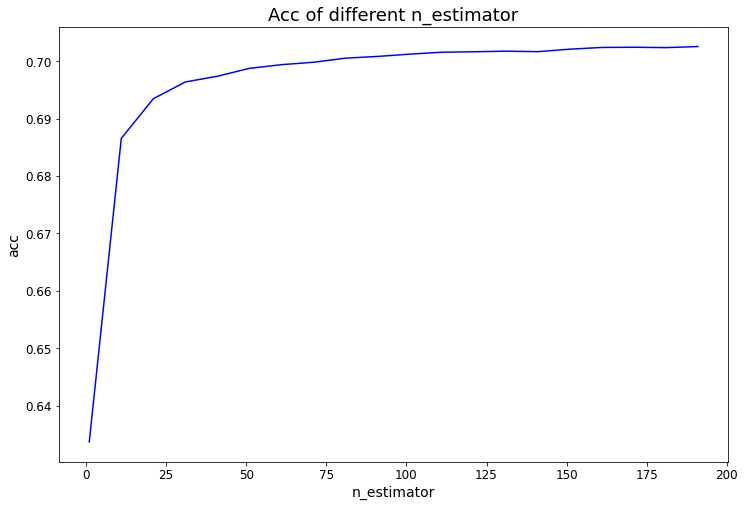

In [16]:
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1
                                ,random_state=42, n_jobs = -1)
    score = cross_val_score(rfc, X_norm, y, cv=kf).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max)*10+1))

# 绘制学习曲线
x = np.arange(1,201,10)
plt.title('Acc of different n_estimator')
plt.xlabel('n_estimator')
plt.ylabel('acc')
plt.plot(x, score_lt, 'b-')
plt.show()

最大得分：0.7031789038027307 子树数量为：196


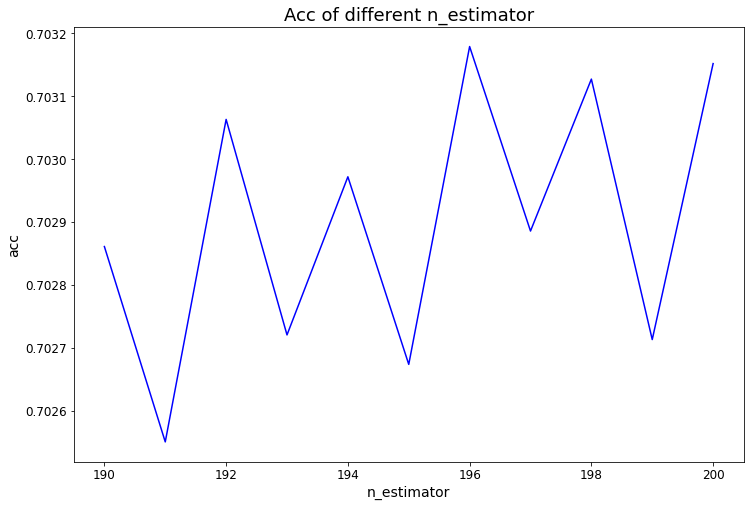

In [17]:
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(190,201):
    rfc = RandomForestClassifier(n_estimators=i
                               ,random_state=42, n_jobs = -1)
    score = cross_val_score(rfc, X_norm, y, cv=kf).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '子树数量为：{}'.format(score_lt.index(score_max) + 190))

# 绘制学习曲线
x = np.arange(190,201)
plt.title('Acc of different n_estimator')
plt.xlabel('n_estimator')
plt.ylabel('acc')
plt.plot(x, score_lt, 'b-')
plt.show()

最大得分：0.7030704753074325 最大深度为：51


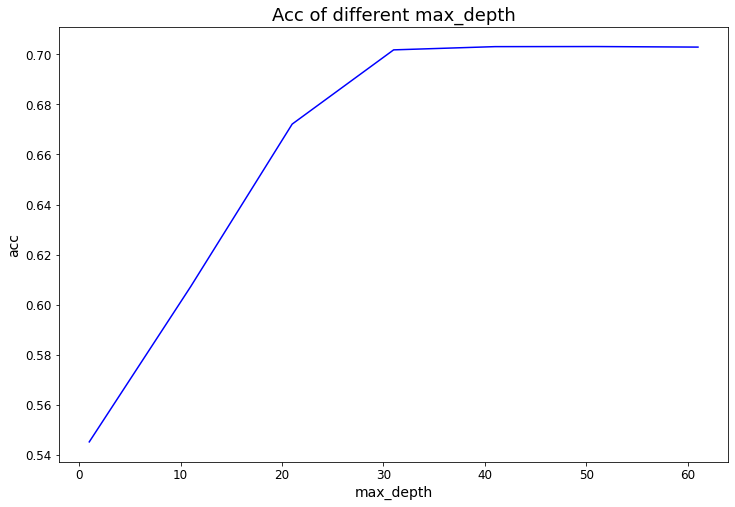

In [18]:
# 搜索max_depth
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(1,71, 10):
    rfc = RandomForestClassifier(n_estimators=196
                               ,random_state=42, max_depth=i ,n_jobs = -1)
    score = cross_val_score(rfc, X_norm, y, cv=kf).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      '最大深度为：{}'.format(score_lt.index(score_max) * 10 + 1))

# 绘制学习曲线
x = np.arange(1, 71, 10)
plt.title('Acc of different max_depth')
plt.xlabel('max_depth')
plt.ylabel('acc')
plt.plot(x, score_lt, 'b-')
plt.show()

最大得分：0.7053819580195672 min_samples_split为：4


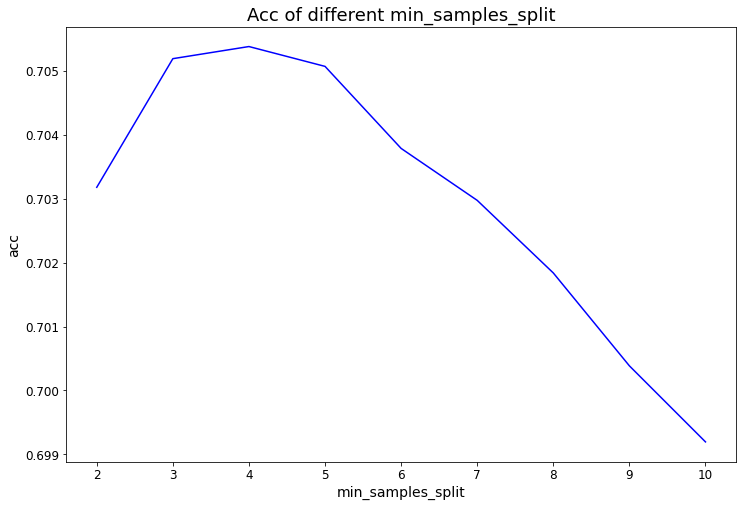

In [20]:
# 搜索 min_samples_split
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(2,11):
    rfc = RandomForestClassifier(n_estimators=196
                               ,random_state=42, min_samples_split = i, n_jobs = -1)
    score = cross_val_score(rfc, X_norm, y, cv=kf).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      'min_samples_split为：{}'.format(score_lt.index(score_max) + 2))

# 绘制学习曲线
x = np.arange(2,11)
plt.title('Acc of different min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('acc')
plt.plot(x, score_lt, 'b-')
plt.show()

最大得分：0.705384422281607 min_samples_leaf：1


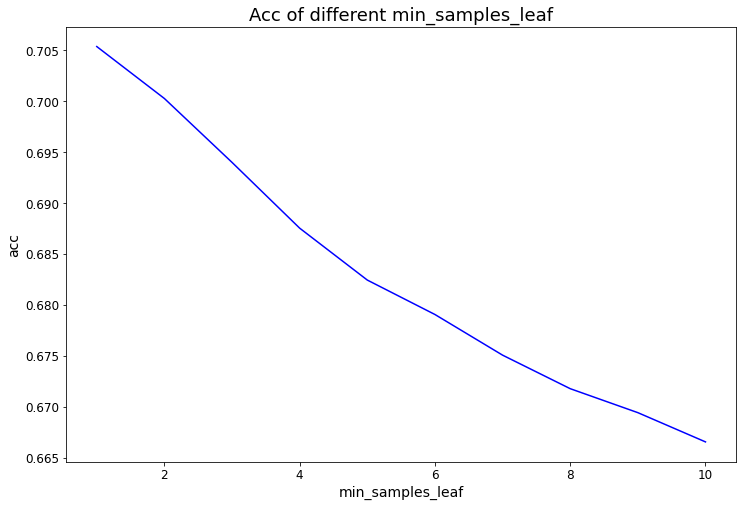

In [22]:
# 搜索 min_samples_leaf
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in range(1,11):
    rfc = RandomForestClassifier(n_estimators=196
                               ,random_state=42, min_samples_split = 4, min_samples_leaf=i, n_jobs = -1)
    score = cross_val_score(rfc, X_norm, y, cv=kf).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      'min_samples_leaf：{}'.format(score_lt.index(score_max) + 1))

# 绘制学习曲线
x = np.arange(1,11)
plt.title('Acc of different min_samples_leaf')
plt.xlabel('min_samples_leaf')
plt.ylabel('acc')
plt.plot(x, score_lt, 'b-')
plt.show()

In [ ]:
np.arange(0.1, 1)

最大得分：0.7105125668347445 max_features：0.9


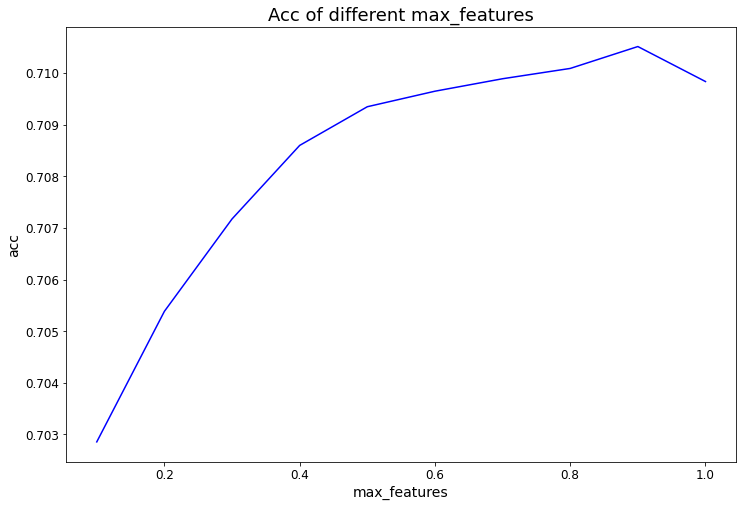

In [23]:
# 搜索 max_features
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in np.arange(0.1, 1.1, 0.1):
    rfc = RandomForestClassifier(n_estimators=196
                               ,random_state=42, min_samples_split = 4, min_samples_leaf=1,
                                 max_features=i , n_jobs = -1)
    score = cross_val_score(rfc, X_norm, y, cv=kf).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      'max_features：{}'.format(score_lt.index(score_max) * 0.1 + 0.1 ))

# 绘制学习曲线
x = np.arange(0.1, 1.1, 0.1)
plt.title('Acc of different max_features')
plt.xlabel('max_features')
plt.ylabel('acc')
plt.plot(x, score_lt, 'b-')
plt.show()

最大得分：0.7113060591022423 criterion：1


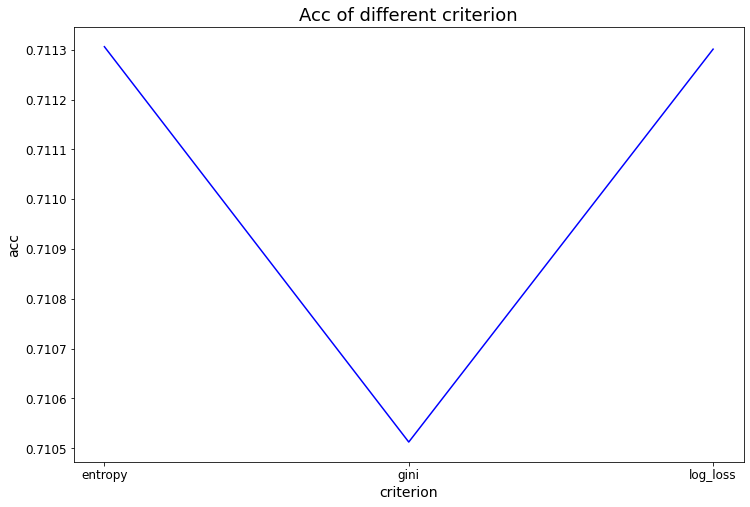

In [24]:
# 搜索 criterion
# 调参，绘制学习曲线来调参n_estimators（对随机森林影响最大）
score_lt = []

# 每隔10步建立一个随机森林，获得不同n_estimators的得分
for i in ['entropy', 'gini', 'log_loss']:
    rfc = RandomForestClassifier(n_estimators=196
                               ,random_state=42, min_samples_split = 4, min_samples_leaf=1,
                                 max_features=0.9, criterion = i , n_jobs = -1)
    score = cross_val_score(rfc, X_norm, y, cv=kf).mean()
    score_lt.append(score)
score_max = max(score_lt)
print('最大得分：{}'.format(score_max),
      'criterion：{}'.format(score_lt.index(score_max) + 1))

# 绘制学习曲线
x = ['entropy', 'gini', 'log_loss']
plt.title('Acc of different criterion')
plt.xlabel('criterion')
plt.ylabel('acc')
plt.plot(x, score_lt, 'b-')
plt.show()

#### catboost调参

In [ ]:
X.head()

In [28]:
from catboost import Pool, cv

categorical_features = ['hashtag', 'time_zone', 'lang', 'tweet_lang', 'day_time', 'season']

cv_dataset = Pool(data=X,
                  label=y,
                  cat_features=categorical_features)

# params = {"iterations": 1000,
#           "depth": 6,
#           "loss_function": "CrossEntropy",
#           "eval_metric": "Accuracy",  # 评估指标设为AUC
#           "learning_rate": 0.01,
#           "task_type" : 'GPU',
#           "devices": '0',
#           "use_best_model": True,
#           "verbose": False,
#           "per_float_feature_quantization":['0:border_count=1024']
#          }

params = {
         'n_estimators':5000,
         'learning_rate': 0.07,
         'eval_metric':'Accuracy',
         'loss_function':'Logloss',
         'random_seed':42,
         'metric_period':500,
         'od_wait':500,
         'task_type':'GPU',
         'depth': 8,
         #'colsample_bylevel':0.7,
         } 

scoring = []
if num_classes == 2:
    scoring = ['Accuracy', 'Precision', 'Recall', 'F1']
elif num_classes > 2:
    scoring = ['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted']
else:
    print(f'Error num_classes of {num_classes}')
    
for score in scoring:
    params['eval_metric']=  score
    scores = cv(cv_dataset,
                params,
                fold_count=3,
    #             verbose=100
                plot = False
                )
    print(scores)

Training on fold [0/3]
0:	learn: 0.5754661	test: 0.5744448	best: 0.5744448 (0)	total: 156ms	remaining: 12m 58s
500:	learn: 0.6343981	test: 0.6315610	best: 0.6315610 (498)	total: 52.6s	remaining: 7m 52s
1000:	learn: 0.6408965	test: 0.6365659	best: 0.6366029 (994)	total: 1m 38s	remaining: 6m 33s
1500:	learn: 0.6450512	test: 0.6389464	best: 0.6389612 (1494)	total: 2m 30s	remaining: 5m 51s
2000:	learn: 0.6465779	test: 0.6400627	best: 0.6401588 (1921)	total: 3m 26s	remaining: 5m 9s
2500:	learn: 0.6491099	test: 0.6411346	best: 0.6412086 (2484)	total: 4m 22s	remaining: 4m 22s
3000:	learn: 0.6507474	test: 0.6412899	best: 0.6413490 (2828)	total: 5m 17s	remaining: 3m 31s
3500:	learn: 0.6526437	test: 0.6425910	best: 0.6426649 (3467)	total: 6m 6s	remaining: 2m 37s
4000:	learn: 0.6539670	test: 0.6430641	best: 0.6431676 (3638)	total: 6m 54s	remaining: 1m 43s
4500:	learn: 0.6546989	test: 0.6433451	best: 0.6434190 (4366)	total: 7m 41s	remaining: 51.1s
4999:	learn: 0.6559002	test: 0.6435151	best: 0.643

Training on fold [0/3]
0:	learn: 0.5903123	test: 0.5895589	best: 0.5895589 (0)	total: 136ms	remaining: 11m 22s
500:	learn: 0.7157900	test: 0.7133266	best: 0.7217546 (77)	total: 52.4s	remaining: 7m 50s
bestTest = 0.7217546131
bestIteration = 77
Training on fold [1/3]
0:	learn: 0.5710614	test: 0.5698784	best: 0.5698784 (0)	total: 139ms	remaining: 11m 34s
500:	learn: 0.7156619	test: 0.7135429	best: 0.7230437 (82)	total: 59.3s	remaining: 8m 52s
bestTest = 0.7230437215
bestIteration = 82
Training on fold [2/3]
0:	learn: 0.6158198	test: 0.6199705	best: 0.6199705 (0)	total: 138ms	remaining: 11m 27s
500:	learn: 0.7268896	test: 0.7187693	best: 0.7242969 (155)	total: 1m 3s	remaining: 9m 25s
bestTest = 0.7242968871
bestIteration = 155
   iterations  test-Precision-mean  test-Precision-std  train-Precision-mean  \
0           0             0.593136            0.025237              0.592398   
1         500             0.715213            0.003082              0.719447   
2         655             

Training on fold [0/3]
0:	learn: 0.4932725	test: 0.4900642	best: 0.4900642 (0)	total: 136ms	remaining: 11m 21s
500:	learn: 0.4433782	test: 0.4362894	best: 0.4900642 (0)	total: 51.3s	remaining: 7m 40s
bestTest = 0.4900641689
bestIteration = 0
Training on fold [1/3]
0:	learn: 0.6323567	test: 0.6266615	best: 0.6266615 (0)	total: 141ms	remaining: 11m 45s
500:	learn: 0.4555804	test: 0.4464537	best: 0.6404566 (1)	total: 1m	remaining: 9m 1s
bestTest = 0.6404565818
bestIteration = 1
Training on fold [2/3]
0:	learn: 0.3967339	test: 0.3973208	best: 0.3973208 (0)	total: 138ms	remaining: 11m 28s
500:	learn: 0.4472931	test: 0.4470451	best: 0.4472669 (462)	total: 1m 1s	remaining: 9m 12s
1000:	learn: 0.4590920	test: 0.4551033	best: 0.4551033 (997)	total: 1m 59s	remaining: 7m 58s
1500:	learn: 0.4675346	test: 0.4599678	best: 0.4599678 (1500)	total: 3m	remaining: 7m 1s
2000:	learn: 0.4712162	test: 0.4613724	best: 0.4614611 (1955)	total: 3m 58s	remaining: 5m 57s
2500:	learn: 0.4758736	test: 0.4640634	bes

Training on fold [0/3]
0:	learn: 0.5374472	test: 0.5352270	best: 0.5352270 (0)	total: 135ms	remaining: 11m 12s
500:	learn: 0.5472392	test: 0.5426619	best: 0.5427271 (493)	total: 52.3s	remaining: 7m 49s
1000:	learn: 0.5602376	test: 0.5527914	best: 0.5527996 (999)	total: 1m 41s	remaining: 6m 45s
1500:	learn: 0.5645962	test: 0.5556587	best: 0.5556587 (1500)	total: 2m 34s	remaining: 5m 59s
2000:	learn: 0.5679362	test: 0.5578076	best: 0.5580336 (1955)	total: 3m 26s	remaining: 5m 9s
2500:	learn: 0.5717032	test: 0.5601168	best: 0.5603179 (2448)	total: 4m 20s	remaining: 4m 19s
3000:	learn: 0.5741810	test: 0.5618676	best: 0.5619664 (2902)	total: 5m 14s	remaining: 3m 29s
3500:	learn: 0.5767923	test: 0.5629927	best: 0.5630889 (3481)	total: 6m 6s	remaining: 2m 36s
4000:	learn: 0.5790981	test: 0.5641053	best: 0.5642257 (3927)	total: 6m 58s	remaining: 1m 44s
4500:	learn: 0.5798558	test: 0.5645021	best: 0.5646468 (4454)	total: 7m 47s	remaining: 51.9s
4999:	learn: 0.5812288	test: 0.5656376	best: 0.565

### 调参后模型测试

In [32]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

# 在最优解附近联合调参

# 创建随机森林分类器
rfc = RandomForestClassifier(n_estimators=196
                               ,random_state=42, min_samples_split = 4, min_samples_leaf=1,
                                 max_features=0.9, criterion = 'gini' , n_jobs = -1)

cat = CatBoostClassifier(n_estimators=5000, 
                         learning_rate=0.07,
                         loss_function='Logloss',
                         random_state=42,
                         metric_period=500,
                         od_wait=500,
                         task_type='GPU',
                         depth = 8,
                         cat_features=categorical_features
                        )

# # 使用GridSearchCV进行网格搜索
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=kf, scoring='accuracy', verbose=2, n_jobs=-1)
# grid_search.fit(X_norm, y)

# # 打印最佳参数组合
# print("Best parameters found: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

# # 打印每个参数组合的得分
# print("Grid search results:")
# means = grid_search.cv_results_['mean_test_score']
# stds = grid_search.cv_results_['std_test_score']
# params = grid_search.cv_results_['params']
# for mean, std, param in zip(means, stds, params):
#     print(f"{param} - Mean score: {mean:.4f}, Std deviation: {std:.4f}")

# # 袋外分数
# best_rf = grid_search.best_estimator_
# print(best_rf.oob_score_)

# # 定义评估指标
num_classes = len(set(y))
print(num_classes)

scoring = []
if num_classes == 2:
    scoring = ['accuracy', 'precision', 'recall', 'f1']
elif num_classes > 2:
    scoring = ['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted']
else:
    print(f'Error num_classes of {num_classes}')


# 训练模型并评估
scores = []

start_time = time.time()
for score_name in scoring:
    score = cross_val_score(rfc, X_norm, y, scoring=score_name, cv=kf, n_jobs=-1)
    scores.append((score.mean(), score.std()))
end_time = time.time()

# 输出结果
for i, score_name in enumerate(scoring):
    mean, std = scores[i]
    print(f"{score_name}: {100 * mean:.2f}±{100 * std:.2f}")

2


Application terminated with error: ??+0 (0x7F691E6DEB94)
??+0 (0x7F691FC7EDAF)
??+0 (0x7F691FC7DE15)
??+0 (0x7F691FC7EFC8)
??+0 (0x7F691EA05712)
??+0 (0x7F691EA0557A)
??+0 (0x7F692CC94AC3)
??+0 (0x7F692CD26850)

(TCatBoostException) /src/catboost/catboost/cuda/cuda_lib/cuda_base.h:261: CUDA error 2: out of memory
uncaught exception:
    address -> 0x401ea1b0410
    what() -> "/src/catboost/catboost/cuda/cuda_lib/cuda_base.h:261: CUDA error 2: out of memory"
    type -> TCatBoostException
Application terminated with error: ??+0 (0x7FE1982DEB94)
??+0 (0x7FE19987EDAF)
??+0 (0x7FE19987DE15)
??+0 (0x7FE19987EFC8)
??+0 (0x7FE198605712)
??+0 (0x7FE19860557A)
??+0 (0x7FE1A6694AC3)
??+0 (0x7FE1A6726850)

(TCatBoostException) /src/catboost/catboost/cuda/cuda_lib/cuda_base.h:261: CUDA error 2: out of memory
uncaught exception:
    address -> 0x3336ed30410
    what() -> "/src/catboost/catboost/cuda/cuda_lib/cuda_base.h:261: CUDA error 2: out of memory"
    type -> TCatBoostException
Application te

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6)}

In [51]:
import joblib
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, stratify=y, random_state=42)
rfc = RandomForestClassifier(n_estimators=196
                               ,random_state=42, min_samples_split = 4, min_samples_leaf=1,
                                 max_features=0.9, criterion = 'gini' , n_jobs = -1)
rfc.fit(X_train, y_train)

predictions = rfc.predict(X_test)

# 评估模型（例如，计算准确率）
accuracy = accuracy_score(y_test, predictions)
print(f'模型准确率：{accuracy}')

joblib.dump(rfc, './models/compressed_random_forest_5.joblib', compress=3)

模型准确率：0.4162025848481664


['./models/compressed_random_forest_5.joblib']

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import numpy as np
from sklearn.utils.class_weight import compute_class_weight 
from torch.optim.lr_scheduler import OneCycleLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_classes, dim_feedforward=128, num_layers=6):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.embedding = nn.Linear(input_dim, dim_feedforward)
        
        # 添加 Batch Normalization 层
        self.batch_norm = nn.BatchNorm1d(dim_feedforward)
        
        # 初始化 Transformer 编码器层
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Dropout 层
        self.dropout = nn.Dropout(0.5)
        
        # 输出层
        self.output_layer = nn.Linear(dim_feedforward, num_classes)
        
        # ReLU 激活函数
        self.relu = nn.ReLU()

    def forward(self, src):
        # src shape: (batch_size, input_dim)
        src = self.embedding(src)  # (batch_size, dim_feedforward)
        
        # 应用批归一化
        src = self.batch_norm(src)
        
        # 应用 ReLU 激活函数
        src = self.relu(src)
        
        src = src.unsqueeze(1)  # (batch_size, 1, dim_feedforward) - Transformer expects seq_len, batch, dim
        output = self.transformer_encoder(src)
        output = output.squeeze(1)  # (batch_size, dim_feedforward)
        
        # 应用 Dropout
        output = self.dropout(output)
        
        output = self.output_layer(output)
        
        return output



model = TransformerModel(input_dim=X.shape[1], num_heads=2, num_classes= len(set(y))).to(device)
def weight_init(m):  #初始化权重
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=0.01)
        
model.apply(weight_init)
# if (y > 2).sum() == 0:
#     criterion = nn.BCELoss().to(device)
# else:
# criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
criterion = nn.CrossEntropyLoss().to(device)
print(criterion)

# lr = 0.0001 准确率0.64
# lr = 0.00005, 65.03

optimizer = optim.Adam(model.parameters(), lr=1e-6)

In [ ]:
# X['weekend'] = X['weekend'].astype(int)

from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)
# 划分数据集
X_tensor = torch.tensor(X, dtype=torch.float32)
# 转换标签数据类型
y_tensor = torch.tensor(y.values, dtype=torch.long)  # 确保y是正确的形状

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

epochs = 100

# 训练和测试
train_loss, test_loss = [], []
train_acc, test_acc = [], []
for epoch in range(epochs):  # 训练5个epoch
    print(f"Epoch {epoch+1}")
    model.train()
    total_loss = 0
    total_num, correct = 0, 0
    s = {0:0, 1:0, 2:0, 3:0, 4:0}
    for data, target in train_loader:
        # 保存参数的初始状态
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step() # 更新梯度
        total_loss += loss.item()
        
        # 计算准确率
        _, predicted = torch.max(output.data, 1)  # 获取每个样本的预测类别
        correct += (predicted == target).sum().item()  # 计算正确预测的数量
        total_num += target.size(0)  # 计算准确率
                
        for i in range(5):
            s[i] += (predicted == i).sum()
        
    for i in range(5):
        print(f"训练集预测为{i}的样本数为：{s[i]}")
    avg_train_loss = total_loss / len(train_loader)
    acc = correct / total_num * 100
    train_loss.append(avg_train_loss)
    train_acc.append(acc)
    print(f"Average Training Loss: {avg_train_loss}, Accuracy: {acc:.2f}%")
          
    model.eval()
    total_loss = 0
    total_num, correct = 0, 0
    s = {0:0, 1:0, 2:0, 3:0, 4:0}
    with torch.no_grad():
        for data, target in test_loader:
            
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(output.data, 1)  # 获取每个样本的预测类别
            correct += (predicted == target).sum().item()  # 计算正确预测的数量
            total_num += target.size(0)  # 计算准确率
            
            for i in range(5):
                s[i] += (predicted == i).sum()
        
    for i in range(5):
        print(f"测试集预测为{i}的样本数为：{s[i]}")
    avg_test_loss = total_loss / len(test_loader)
    acc = correct / total_num * 100
    test_loss.append(avg_test_loss)
    test_acc.append(acc)
    print(f"Test Loss: {avg_test_loss}, Accuracy: {acc:.2f}%")
    
torch.save(model, './models/transformer_balance_5_origin.pth')

In [ ]:
X.info()

In [ ]:
import torch
from sklearn.preprocessing import MinMaxScaler
categorical_features = ['hashtag', 'lang', 'tweet_lang', 'time_zone', 'season', 'day_time', 'weekend', 'mood_label', 'happy']
numerical_features = [i for i in X.columns if i not in categorical_features]
print(categorical_features, '\n', numerical_features)

categories = tuple(X.loc[:, categorical_features].nunique())
print(categories)

# 计算均值和方差
X[numerical_features] = MinMaxScaler().fit_transform(X[numerical_features])
means = X[numerical_features].mean()
std = X[numerical_features].std()

# 转换成tensor
cont_mean_std = torch.tensor([means.values, std.values], dtype = torch.float32).T

# 打印结果
print(cont_mean_std)

In [ ]:
import torch
import torch.nn as nn
from tab_transformer_pytorch import TabTransformer
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.info()
y_test.value_counts()

In [ ]:
X_train_cat = X_train[categorical_features]
X_train_con = X_train[numerical_features]
X_test_cat = X_test[categorical_features]
X_test_con = X_test[numerical_features]

# 将数据转换为 PyTorch 张量
X_train_categ = torch.tensor(X_train_cat.values, dtype=torch.long)
X_train_cont = torch.tensor(X_train_con.values, dtype=torch.float32)
X_test_categ = torch.tensor(X_test_cat.values, dtype=torch.long)
X_test_cont = torch.tensor(X_test_con.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# 创建数据集和数据加载器
batch_size = 64
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:


import logging
from datetime import datetime
# 获取当前时间，并格式化为字符串
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# 使用时间戳生成日志文件名
log_filename = f'./exp/TabTransformer_{current_time}.log'

# 配置logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s', 
                    filename=log_filename,  # 动态生成的日志文件名
                    filemode='w')

logger = logging.getLogger()

# 定义 TabTransformer 模型
l = len(categorical_features) + len(numerical_features)
model = TabTransformer(
    categories = categories,                # 分类特征的类别数量
    num_continuous = len(numerical_features),   # 连续特征数量
    dim = 64,                           # 模型维度
    dim_out = 5,                        # 输出维度（5类分类）
    depth = 6,                          # 模型深度
    heads = 8,                          # 注意力头数量
    attn_dropout = 0.1,                 # 注意力层 dropout
    ff_dropout = 0.1,                   # 前馈层 dropout
    mlp_hidden_mults = (4, 2),  # MLP 隐藏层相对维度
    mlp_act = nn.ReLU(),           # MLP 激活函数
    continuous_mean_std = cont_mean_std # 连续特征的均值和标准差
)
logger.info(model)
model

In [ ]:
# 将模型移动到GPU（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# 转换数据到 GPU
X_train_categ = X_train_categ.to(device)
X_train_cont = X_train_cont.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_categ = X_test_categ.to(device)
X_test_cont = X_test_cont.to(device)
y_test_tensor = y_test_tensor.to(device)

# 定义优化器
lr = 1e-5
optimizer = Adam(model.parameters(), lr=lr)

# 训练模型
num_epochs = 50
test_losses = []
test_accs = []
train_losses = []
train_accs = []

logger.info("Trainning params:")
logger.info(f"lr: {lr}")
logger.info(f"batch_size: {batch_size}")
logger.info(f"num_epochs: {num_epochs}")          
logger.info("Start trainning......")
for epoch in range(num_epochs):
    model.train()
    logger.info(f"---------------------------------- Epoch {epoch + 1} / Epoch {num_epochs} ----------------------------------")
    total_loss, total = 0.0, 0
    correct, num = 0, 0
    for X_batch_categ, X_batch_cont, y_batch in train_loader:
        X_batch_categ = X_batch_categ.to(device)
        X_batch_cont = X_batch_cont.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch_categ, X_batch_cont)
        loss = F.cross_entropy(logits, y_batch)
        preds = torch.argmax(logits, dim=1)
            
        correct += (preds == y_batch).sum().item()  # 计算正确预测的数量
        total += y_batch.size(0)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    train_acc = correct / total
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # 评估模型
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    s = {0:0, 1:0, 2:0, 3:0, 4:0}
    with torch.no_grad():
        for X_batch_categ, X_batch_cont, y_batch in test_loader:
            X_batch_categ = X_batch_categ.to(device)
            X_batch_cont = X_batch_cont.to(device)
            y_batch = y_batch.to(device)

            test_logits = model(X_batch_categ, X_batch_cont)
            test_loss += F.cross_entropy(test_logits, y_batch, reduction='sum').item()
            preds = torch.argmax(test_logits, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            
            for i in range(5):
                s[i] += (preds == i).sum()
    
    for i in range(5):
        logger.info(f"测试集预测为{i}的样本数为：{s[i]}")
    test_loss /= total
    accuracy = correct / total
    test_losses.append(test_loss)
    test_accs.append(accuracy)
    logger.info(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')
    
torch.save(model, './models/tabtransformer_5.pth')

In [ ]:
import matplotlib.pyplot as plt
# 设置全局图表大小
plt.rc('figure', figsize=(12, 8))
plt.rc('axes', titlesize=18)  # 设置轴标题的字体大小
plt.rc('axes', labelsize=14)  # 设置轴标签的字体大小
plt.rc('xtick', labelsize=12)  # 设置x轴刻度标签的字体大小
plt.rc('ytick', labelsize=12)  # 设置y轴刻度标签的字体大小
plt.rc('legend', fontsize=12)  # 设置图例的字体大小

plt.figure()
plt.title('Loss and acc of the train process')
plt.plot(range(num_epochs), train_losses, 'b--', label='train_loss')
plt.plot(range(num_epochs), [x for x in train_accs], 'g', label = 'train_acc')
plt.plot(range(num_epochs), test_losses, 'r--', label = 'test_loss')
plt.plot(range(num_epochs), [x for x in test_accs], 'black', label = 'test_acc')
plt.xlabel('epoch')
plt.ylabel('acc / loss')
plt.legend(loc='best')
plt.show()